In [14]:
import os
import pickle
from pathlib import Path

# import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from matplotlib.lines import Line2D
from torch.backends.cudnn import allow_tf32

# plot_folder = Path("/Users/jg/Desktop/upper_limb/paper_figures-3")
# os.makedirs(plot_folder, exist_ok=True)
# data_folder = Path("/Users/jg/Desktop/upper_limb/paper_data-2")


In [15]:
participants = [
    "P_149",
    "P_238",
    "P_407",
    "P_426",
    "P_577",
    "P_668",
    "P_711",
    "P_950",
    "P7_453",
    "P6_820",
]
online_participants = [
    "P_149",
    "P_238",
    "P_407",
    "P_426",
    "P_577",
    "P_668",
    "P_711",
    "P_950",
    "P7_453",
]
targets = [
    "indexAng",
    "midAng",
    "ringAng",
    "pinkyAng",
    "thumbInPlaneAng",
    "thumbOutPlaneAng",
    "wristFlex",
]
recordings = [
    "thumbFlEx",
    "thumbAbAd",
    "indexFlEx",
    "mrpFlEx",
    "fingersFlEx",
    "wristFlEx",
    "handOpCl",
    "pinchOpCl",
    "pointOpCl",
]
test_recordings = ["keyOpCl", "wristFlHandCl", "indexFlDigitsEx"]

df = pd.DataFrame(
    index=participants,
    columns=pd.MultiIndex.from_product(
        [
            [
                "init",
                "offline",
                "comp",
                "comp_interp",
                "pert_init",
                "pert_offline",
                "pert_comp",
                "pert_comp_interp",
            ],
            ["val", "test", "total"],
        ]
    ),
)
df.loc[:, "participants"] = df.index


In [16]:
participant = "P_950"
recording = "fingersFlEx"
data_dir = Path(
    f"/Users/jorisg/projects/biomech_PCP/data/{participant}/recordings/{recording}/experiments/1"
)

perturber_path = Path(
    f"/Users/jorisg/projects/biomech_PCP/data/{participant}/online_trials/perturb/perturber.npy"
)

config_path = Path(
    f"/Users/jorisg/projects/biomech_PCP/data/{participant}/configs/modular.yaml"
)
perturber = np.load(perturber_path)
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

features = config["parameters"]["features"]["value"]
print(features)

try:
    emg = np.load(data_dir / "cropped_aligned_emg.npy")
except:  # noqa: E722
    emg = np.load(data_dir / "cropped_emg.npy")

int_features = [int(feature[1]) for feature in features]
emg = emg[:, int_features]

perturbed_emg = (perturber @ emg.T).T

[['emg', '0'], ['emg', '1'], ['emg', '2'], ['emg', '4'], ['emg', '10'], ['emg', '11'], ['emg', '12'], ['emg', '13']]


In [18]:
perturbed_emg.shape

(1800, 8)

In [19]:
emg.shape

(1800, 8)

In [ ]:
import pandas as pd

# Create DataFrames for easier correlation calculation
emg_df = pd.DataFrame(emg, columns=[f"emg_{i}" for i in range(emg.shape[1])])
perturbed_emg_df = pd.DataFrame(
    perturbed_emg, columns=[f"perturbed_emg_{i}" for i in range(perturbed_emg.shape[1])]
)

# Concatenate along columns
combined_df = pd.concat([emg_df, perturbed_emg_df], axis=1)

# Compute correlation matrix between all emg and perturbed_emg channels
corr_matrix = combined_df.corr().loc[emg_df.columns, emg_df.columns]

# Display the correlation matrix
corr_matrix

,emg_0,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7
emg_0,1.000000,0.528042,0.434750,0.542814,0.397394,0.593050,0.331683,0.596126
emg_1,0.528042,1.000000,0.044309,0.884354,0.065919,0.816453,-0.048288,0.809658
emg_2,0.434750,0.044309,1.000000,-0.005882,0.948058,-0.032590,0.618379,0.008812
emg_3,0.542814,0.884354,-0.005882,1.000000,0.020513,0.815462,-0.128530,0.803950
emg_4,0.397394,0.065919,0.948058,0.020513,1.000000,-0.043615,0.642850,0.001576
emg_5,0.593050,0.816453,-0.032590,0.815462,-0.043615,1.000000,-0.212076,0.923614
emg_6,0.331683,-0.048288,0.618379,-0.128530,0.642850,-0.212076,1.000000,-0.133017
emg_7,0.596126,0.809658,0.008812,0.803950,0.001576,0.923614,-0.133017,1.000000


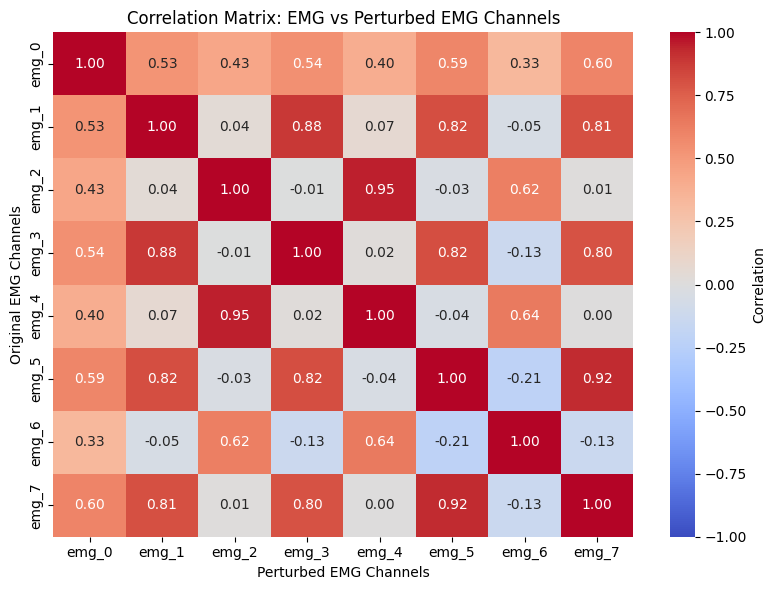

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    cbar_kws={"label": "Correlation"},
)
plt.title("Correlation Matrix: EMG vs Perturbed EMG Channels")
plt.xlabel("Perturbed EMG Channels")
plt.ylabel("Original EMG Channels")
plt.tight_layout()
plt.show()

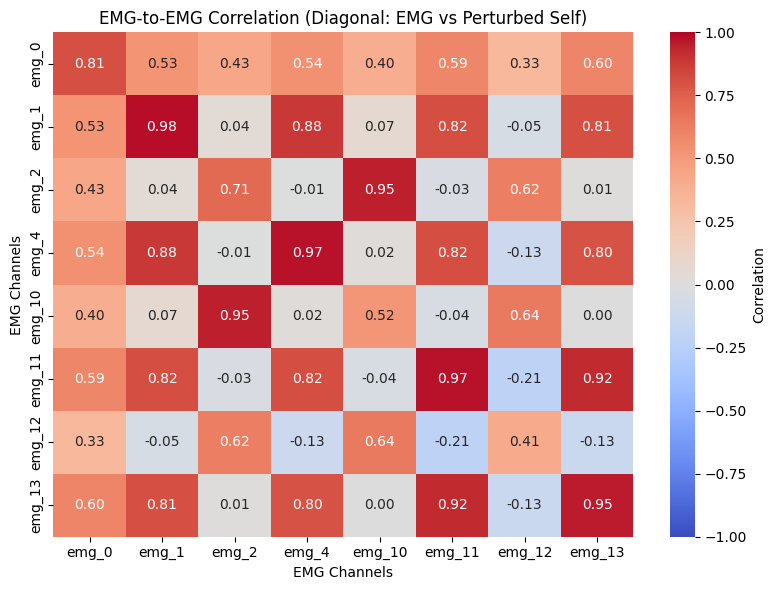

In [26]:
import numpy as np
import pandas as pd

# Compute emg-to-emg correlation matrix
emg_corr = pd.DataFrame(
    np.corrcoef(emg.T), columns=emg_df.columns, index=emg_df.columns
)

# Compute correlation between each emg channel and its perturbed counterpart
self_corr = [
    np.corrcoef(emg[:, i], perturbed_emg[:, i])[0, 1] for i in range(emg.shape[1])
]

# Replace diagonal with emg-to-perturbed self correlation
for i in range(emg.shape[1]):
    emg_corr.iloc[i, i] = self_corr[i]

emg_corr.columns = [f"emg_{int_features[i]}" for i in range(emg.shape[1])]
emg_corr.index = [f"emg_{int_features[i]}" for i in range(emg.shape[1])]
# Visualize
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(
    emg_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    cbar_kws={"label": "Correlation"},
)
plt.title("EMG-to-EMG Correlation (Diagonal: EMG vs Perturbed Self)")
plt.xlabel("EMG Channels")
plt.ylabel("EMG Channels")
plt.tight_layout()
plt.show()


In [36]:
import glob
from pathlib import Path

import yaml
from deepdiff import DeepDiff

base_path = Path("data/P_149/configs/modular.yaml")
with open(base_path, "r") as f:
    base_config = yaml.safe_load(f)

# Find all modular.yaml files in data/*/configs/
all_configs = [
    Path(f"data/{p}/configs/modular.yaml")
    for p in participants
    if Path(f"data/{p}/configs/modular.yaml") != base_path
    and Path(f"data/{p}/configs/modular.yaml").exists()
]
all_configs = [Path(p) for p in all_configs if Path(p) != base_path]

for config_path in all_configs:
    with open(config_path, "r") as f:
        other_config = yaml.safe_load(f)
    diff = DeepDiff(base_config, other_config, ignore_order=True)
    print(f"\n--- Differences with {config_path} ---")
    if diff:
        print(diff)
    else:
        print("No differences.")


--- Differences with data/P_238/configs/modular.yaml ---
{'values_changed': {"root['name']": {'new_value': 'P_238', 'old_value': 'P_149'}}}

--- Differences with data/P_426/configs/modular.yaml ---
{'values_changed': {"root['name']": {'new_value': 'P_426', 'old_value': 'P_149'}}}

--- Differences with data/P_668/configs/modular.yaml ---
{'values_changed': {"root['name']": {'new_value': 'P_668', 'old_value': 'P_149'}}}

--- Differences with data/P_711/configs/modular.yaml ---
{'values_changed': {"root['name']": {'new_value': 'P_711', 'old_value': 'P_149'}}}

--- Differences with data/P_950/configs/modular.yaml ---
{'values_changed': {"root['name']": {'new_value': 'P_950', 'old_value': 'P_149'}}}

--- Differences with data/P7_453/configs/modular.yaml ---
{'values_changed': {"root['name']": {'new_value': 'P7_453', 'old_value': 'P_149'}, "root['parameters']['targets']['value'][3]": {'new_value': ['Right', 'pinkyAng'], 'old_value': ['Left', 'pinkyAng']}, "root['parameters']['targets']['val

In [ ]:
for participant in participants:
    if participant not in os.listdir("/Users/jorisg/projects/biomech_PCP/data"):
        print(f"Participant {participant} not found in data directory.")

for participant in os.listdir("/Users/jorisg/projects/biomech_PCP/data"):
    if participant.startswith("P_") and participant not in participants:
        print(
            f"Participant {participant} is not in the predefined list of participants."
        )

# Check if all participants have the same number of features

Participant P_339 is not in the predefined list of participants.
Participant P_556 is not in the predefined list of participants.
Participant P_577 copy.zip is not in the predefined list of participants.
Participant P_684 is not in the predefined list of participants.


In [ ]:
# copy /Users/jorisg/projects/biomech_PCP/data/P_149/configs/modular_initialization.yaml to all participants, change
# the first line from "name: P_149" to "name: {participant}"
from pathlib import Path
import yaml


def copy_initialization_config(participants, base_path):
    base_config_path = Path(base_path)
    with open(base_config_path, "r") as f:
        base_config = yaml.safe_load(f)

    for participant in participants:
        participant_config_path = Path(
            f"data/{participant}/configs/modular_initialization.yaml"
        )
        if not participant_config_path.exists():
            # Create the directory if it doesn't exist
            # participant_config_path.parent.mkdir(parents=True, exist_ok=True)
            # Modify the base config for the current participant
            base_config["name"] = participant
            with open(participant_config_path, "w") as f:
                yaml.dump(base_config, f)
            print(f"Copied config to {participant_config_path}")


copy_initialization_config(
    participants, "data/P_149/configs/modular_initialization.yaml"
)


Copied config to data/P_238/configs/modular_initialization.yaml
Copied config to data/P_407/configs/modular_initialization.yaml
Copied config to data/P_426/configs/modular_initialization.yaml
Copied config to data/P_577/configs/modular_initialization.yaml
Copied config to data/P_668/configs/modular_initialization.yaml
Copied config to data/P_711/configs/modular_initialization.yaml
Copied config to data/P_950/configs/modular_initialization.yaml
Copied config to data/P7_453/configs/modular_initialization.yaml
Copied config to data/P6_820/configs/modular_initialization.yaml


In [ ]:
np.sqrt(3.0) * np.sqrt(2.0 / (1 + 0.01**2))


2.44936727748086

In [ ]:
python s4_train.py --person_dir P_149 --intact_hand Left --config_name modular_initialization -hs